##Disclaimer

The algorithms and strategies presented in this tutorial are for educational purposes only and are not intended to provide financial or trading advice. The performance of the models and strategies demonstrated herein is based on historical data and may not accurately predict future market behavior. Trading financial markets involves substantial risk and may not be suitable for all investors. You should consult with a qualified financial advisor before making any investment decisions. The authors and publishers of this tutorial are not responsible for any losses incurred as a result of using the information contained within.

In [ ]:
# Load dependencies
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn import utils
from sklearn.linear_model import LogisticRegression

import re
import seaborn as sns
import matplotlib.pyplot as plt

## Load & clean data
You can find the data published on Kaggle at https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news?resource=download. According to the Kaggle authors, the dataset contains the sentiment for financial news headlines from the perspective of a retail investor.

The original dataset can be found in *Malo, P., Sinha, A., Takala, P., Korhonen, P. and Wallenius, J. (2014): “Good debt or bad debt: Detecting semantic orientations in economic texts.” Journal of the American Society for Information Science and Technology.*

You can also find a copy of the raw data here: https://drive.google.com/file/d/1JbIqZds_k6SJm66vJFn5vnuB8MI0noFc/view?usp=sharing

Load the file you downloaded (SentimentAnalysis_Kaggle.csv) into Session storage.

In [ ]:
df = pd.read_csv("SentimentAnalysis_Kaggle.csv", delimiter=",", encoding="latin-1")
df.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [ ]:
# Rename the columns as the CSV doesn't appear to have the name of the columns specified correctly
df = df.rename(columns={'neutral':'sentiment',
                        'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .':'message'})

In [ ]:
df.head()

,sentiment,message
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


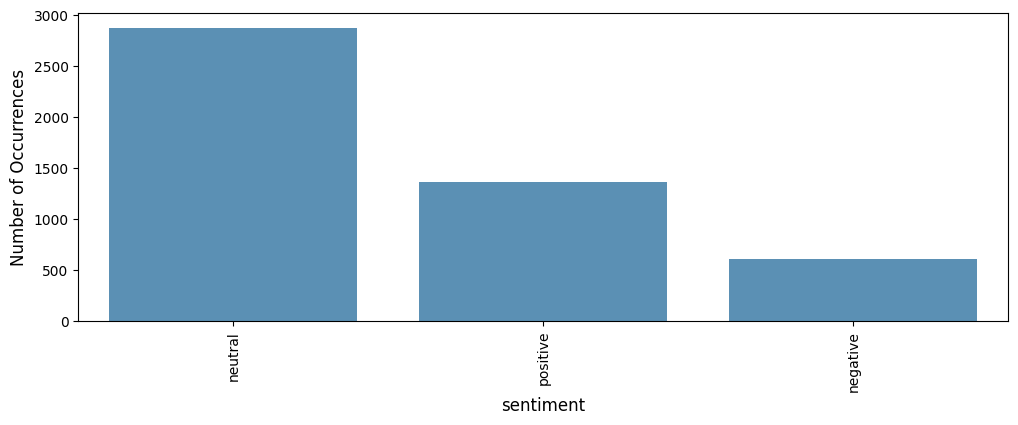

In [ ]:
# Investigate the distributions of sentiment values. i.e. check if we have an equal number of objects in each class.
count_sentiment_instances = df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=count_sentiment_instances.index, y=count_sentiment_instances.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();

Observe how we mostly have neutral sentiment news. More, the least frequent news are news with negative sentiments.

In [ ]:
# Encode the sting values of the sentiment as numeric in a new column called "label"
sentiment  = {'positive': 0,'neutral': 1,'negative':2}

df["label"] = [sentiment[item] for item in df["sentiment"]]
df.head()

,sentiment,message,label
0,neutral,Technopolis plans to develop in stages an area...,1
1,negative,The international electronic industry company ...,2
2,positive,With the new production plant the company woul...,0
3,positive,According to the company 's updated strategy f...,0
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,0


In [ ]:
# Define a helper function that will find a specific entry in the dataset (based
# on it's index) and then display the text and sentiment for that entry.
def print_message(index):
    example = df[df.index == index][['message', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])

print("--- Example usage ---")
print_message(12)

--- Example usage ---
Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn .
Message: positive


In [ ]:
# Remove any unwanted characters from the text. Usually texts coming from the
# internet have all sorts of characters inside. We always need to preprocess them
# to ensure they are clean as per our needs.
from bs4 import BeautifulSoup
def remove_unwanted_characters(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text)
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['message'] = df['message'].apply(remove_unwanted_characters)

<ipython-input-169-23a43444d435>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


##Build a model

Develop and train a model to map a processed text to a sentiment value (positive, negative, or netural).

In [ ]:
# Split the data into two sets. One set (train) is used for training the
# classifier to distinguish between sentiments. The other set (test) is used to
# determine how well does the classifier perform on unseen data (i.e. how well
# it generalises)
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.000001 , random_state=42)

In [ ]:
# Convert the raw text into a sequence of numbers using the nltk package, gensim
# doc2vec, and keras.

import nltk
nltk.download('punkt')

from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
import gensim
from gensim.models.doc2vec import TaggedDocument

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['message']),
                             tags=[r["sentiment"]]), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Develop a document to vector model to embedd the tokenized texts into
# multidimensional vectors. These embeddings are later used to develop the
# sentiment classifiers.
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1,
                    workers=1, alpha=0.065, min_alpha=0.065)

# Use training texts to build the model vocabulary
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 4844/4844 [00:00<00:00, 727172.82it/s]


In [ ]:
# Train the embeddings using the available training data
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]),
                    total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 4844/4844 [00:00<00:00, 1207704.25it/s]


CPU times: user 14.2 s, sys: 107 ms, total: 14.3 s
Wall time: 15.5 s


In [ ]:
d2v_model.wv.most_similar(positive=['profit'], topn=10)

[('loss', 0.8923762440681458),
 ('profits', 0.8125098347663879),
 ('income', 0.7607591152191162),
 ('bill', 0.7528855204582214),
 ('suspend', 0.7524800300598145),
 ('sales', 0.7458061575889587),
 ('petition', 0.7315126657485962),
 ('withdrawn', 0.7073655724525452),
 ('limit', 0.7065842747688293),
 ('result', 0.7055516839027405)]

In [ ]:
d2v_model.wv.most_similar(positive=['investment'], topn=10)

[('syndicated', 0.8279459476470947),
 ('detailing', 0.8058988451957703),
 ('hardest', 0.7549338936805725),
 ('grievance', 0.7470617294311523),
 ('municipality', 0.7327448129653931),
 ('organization', 0.7228282690048218),
 ('fund', 0.714743971824646),
 ('eur150m', 0.7128603458404541),
 ('foreign', 0.7102416157722473),
 ('placed', 0.7087095975875854)]

In [ ]:
d2v_model.wv.most_similar(positive=['broke'], topn=10)

[('mold', 0.9749249219894409),
 ('breakfast', 0.8834859132766724),
 ('aboavista', 0.878757119178772),
 ('cereals', 0.8781835436820984),
 ('gather', 0.877431333065033),
 ('580', 0.8699619770050049),
 ('www.icis.com', 0.8644804954528809),
 ('macro-economic', 0.8624515533447266),
 ('brockpahler', 0.8601660132408142),
 ('143.9', 0.8562218546867371)]

### Develop an LSTM model

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# The maximum number of words to be used. (most frequent)
max_features = 500000

# Max number of words in each text.
max_sequence_length = 100

# Create a tokenizer that uses at most 50 words and filters unwanted characters.
tokenizer = Tokenizer(num_words=max_features, split=' ',
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

# Fit the tokenizer on the training data
tokenizer.fit_on_texts(df['message'].values)

# Convert texts according to the tokenizer and pad sequences
X = tokenizer.texts_to_sequences(df['message'].values)
X = pad_sequences(X, maxlen=max_sequence_length)

print('Found %s unique tokens.' % len(X))
print('Shape of data tensor:', X.shape)

Found 4845 unique tokens.
Shape of data tensor: (4845, 100)


In [ ]:
# Save the vectors in a new matrix
embedding_dim = 20
vocab_size = min(max_features, len(tokenizer.word_index)) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for i, vec in enumerate(d2v_model.dv.vectors):
    if i < vocab_size:
        embedding_matrix[i] = vec

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding


# init layer
model = Sequential()

# emmbed word vectors
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=20,
                    input_length=X.shape[1],
                    weights=[embedding_matrix],
                    trainable=True))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 20)           202160    
                                                                 
 lstm_7 (LSTM)               (None, 50)                14200     
                                                                 
 dense_7 (Dense)             (None, 3)                 153       
                                                                 
Total params: 216513 (845.75 KB)
Trainable params: 216513 (845.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Split the data into training and test datasets (15% of the data is used to
# test the model performance on unseen data)
y = pd.get_dummies(df['sentiment']).values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15,
                                                    random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4118, 100) (4118, 3)
(727, 100) (727, 3)


In [ ]:
batch_size = 32
history = model.fit(X_train, y_train,
                    epochs = 50, batch_size=batch_size, verbose = 2)

Epoch 1/50
129/129 - 10s - loss: 0.5615 - acc: 0.5811 - 10s/epoch - 74ms/step
Epoch 2/50
129/129 - 6s - loss: 0.4899 - acc: 0.6469 - 6s/epoch - 50ms/step
Epoch 3/50
129/129 - 6s - loss: 0.3669 - acc: 0.7467 - 6s/epoch - 43ms/step
Epoch 4/50
129/129 - 7s - loss: 0.2766 - acc: 0.8096 - 7s/epoch - 57ms/step
Epoch 5/50
129/129 - 6s - loss: 0.2150 - acc: 0.8558 - 6s/epoch - 43ms/step
Epoch 6/50
129/129 - 8s - loss: 0.1449 - acc: 0.9191 - 8s/epoch - 59ms/step
Epoch 7/50
129/129 - 5s - loss: 0.0872 - acc: 0.9602 - 5s/epoch - 42ms/step
Epoch 8/50
129/129 - 6s - loss: 0.0593 - acc: 0.9716 - 6s/epoch - 47ms/step
Epoch 9/50
129/129 - 7s - loss: 0.0390 - acc: 0.9835 - 7s/epoch - 54ms/step
Epoch 10/50
129/129 - 5s - loss: 0.0327 - acc: 0.9864 - 5s/epoch - 42ms/step
Epoch 11/50
129/129 - 8s - loss: 0.0370 - acc: 0.9845 - 8s/epoch - 58ms/step
Epoch 12/50
129/129 - 5s - loss: 0.0360 - acc: 0.9866 - 5s/epoch - 42ms/step
Epoch 13/50
129/129 - 11s - loss: 0.0226 - acc: 0.9910 - 11s/epoch - 87ms/step
Epoc

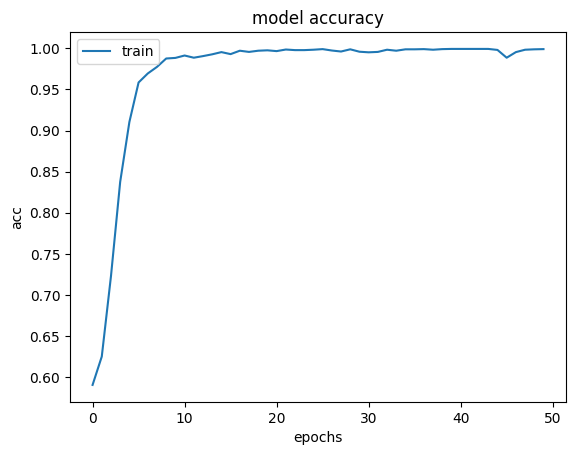

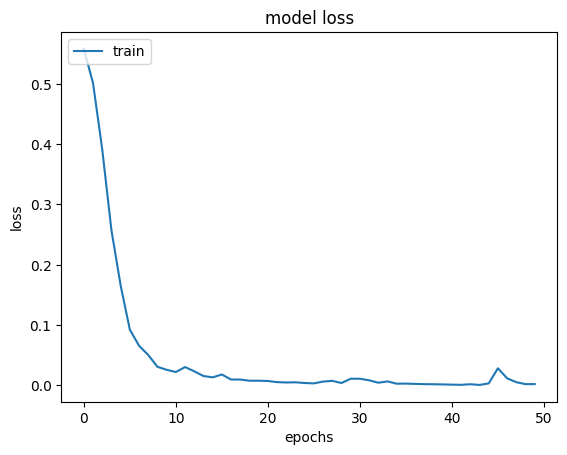

In [ ]:
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=2)
_, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

129/129 - 3s - loss: 0.0033 - acc: 0.9981 - 3s/epoch - 23ms/step
23/23 - 0s - loss: 1.1240 - acc: 0.7153 - 446ms/epoch - 19ms/step
Train: 0.998, Test: 0.7153


In [ ]:
# Take an indepth look at the model performance on the test set.
# To investigate the model behaviour, we need to check how the model performs
# depending on the types of inputs provided.

# We will also analyse the "sensitivity" of the model with respect to the minum
# probability threshold used for making a prediction.

import numpy as np

# Predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)

# Predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs, axis=1)
rounded_labels = np.argmax(y_test, axis=1)


In [ ]:
# Create a confusion matrix to see what errors is the model making (if any)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)

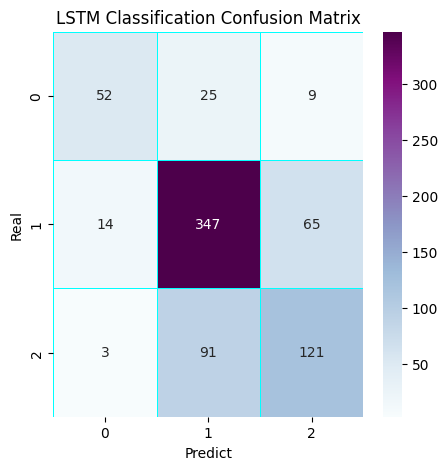

In [ ]:
# Display the confusion matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Predict')
plt.ylabel('Real')
plt.show()

#Example

Example usage of the trained model. Below we have an example on how to use the model to predict the text of a random input text.

In [ ]:
message = ['bad bad bad bad bad worse The local electronics industry is expected to remain stable amid layoff concerns surrounding Japanese electronics giants operating in the country, an official says.']
seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)
pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 45ms/step
[[9.9999309e-01 6.4190654e-06 4.8593887e-07]] 0


References:
- https://www.kaggle.com/code/khotijahs1/nlp-financial-news-sentiment-analysis#NLP